In [1]:
import math
import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import kornia as K
from scipy import ndimage
import numpy as np

After setting the DATASET_PATH to download the required MNIST data, we will perform the necessary transformations on the dataset.
We will begin by converting the images to tensors and normalizing them.

Then we will set a TEST_IMG_INDEX to use as our testing image throughout the rest of the program.

Extract the img from the test set and verify through plotting it.

Image Size: torch.Size([28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100, 237,
         121,   0,   0,   0,   0,   0,   0,  13,  48,  18,   0,   0,   0,   0],
        [  0,

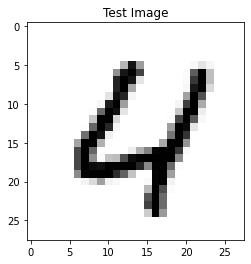

In [3]:
DATASET_PATH = "./data"

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

TEST_IMG_INDEX = 64

img = train_set.data[TEST_IMG_INDEX]
print(f"Image Size: {img.size()}")
print(img)
plt.title("Test Image")
plt.imshow(img, cmap="Greys")

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

Then we will clone the image several times to leave us with the required copies of the image.
    We will need to generate a noisy image as well as a noisy image with random inpainting lines removed.

First we will generate random noise in the image using a random array of the same size and applying the noise.

Then we will iterate through the image with a random chance to remove a vertical scanline from the image. This is done with the intention of mirroring removed scanlines for inpainting.

In [33]:
input_imgs = torch.clone(train_set.data)
input_imgs.data.to(torch.float)
print(input_imgs.data.size())
noise = torch.rand(input_imgs.data.size(), device=train_set.data.device) * 127


noisy_imgs = input_imgs.data.add(noise.data.int())
noisy_imgs.data.clamp_(min=0, max=255)

clean_img = input_imgs.data[TEST_IMG_INDEX]
noisy_img = noisy_imgs.data[TEST_IMG_INDEX]

clean_img_removed = torch.clone(clean_img)
noisy_img_removed = torch.clone(noisy_img)

rand_chance = np.random.randint(0, 28, size=28)
rand_lines = np.random.randint(0, 28, size=28)

for i in rand_lines:
    if rand_chance[i] < 4:
        for j in range(clean_img_removed.size()[0]):
            clean_img_removed[j][rand_lines[i]] = 127

for i in rand_lines:
    if rand_chance[i] < 4:
        for j in range(noisy_img_removed.size()[0]):
            noisy_img_removed[j][rand_lines[i]] = 127

torch.Size([60000, 28, 28])


The following plots verify the different images

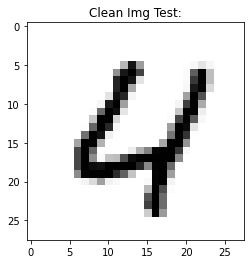

In [34]:
plt.title("Clean Img Test:")
plt.imshow(clean_img, cmap="Greys")

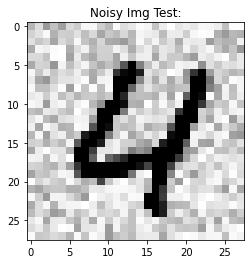

In [35]:
plt.title("Noisy Img Test:")
plt.imshow(noisy_img, cmap="Greys")

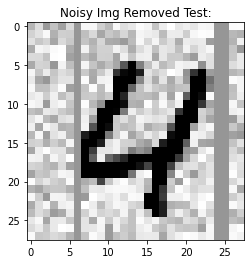

In [36]:
plt.title("Noisy Img Removed Test:")
plt.imshow(noisy_img_removed, cmap="Greys")

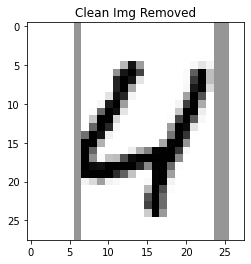

In [37]:
plt.title("Clean Img Removed")
plt.imshow(clean_img_removed, cmap="Greys")

This energy based model relies on analyzing the total variation between vertical and horizontal localizations differently.
Thus we will assign ALPHA and BETA parameters to applying differing weights to vertical and horizontal scan lines in the model.

In [38]:
ALPHA = 0.01
BETA = 0.05

The model also relies on the application of gradients in both axises of the image.
Gradient calculations are done with applying a sobel convolutional filter across the images. By default, the padding on the edge is done with 0-padding.

In the gradient calculations we can see that there is clear edge detection on the written digit, but also a clear edge develops surrounding the removed scanlines.

Gradient Calculation Test:


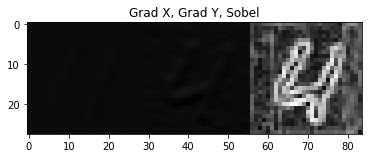

In [39]:
print("Gradient Calculation Test:")

sy = ndimage.sobel(noisy_img_removed,axis=0,mode='constant')
sx = ndimage.sobel(noisy_img_removed,axis=1,mode='constant')

sobel=np.hypot(sx,sy)
plots = np.concatenate((sx*ALPHA, sy*BETA, sobel), axis = 1)
plt.title("Grad X, Grad Y, Sobel")
plt.imshow(plots,cmap=plt.cm.gray)
plt.show()

We will convert the gradient calculation into a function to use in the minimization.

In [40]:
def grads(img):
    sy = ndimage.sobel(img,axis=0,mode='nearest')
    sx = ndimage.sobel(img,axis=1,mode='nearest')

    #sobel=np.hypot(sx,sy)

    return sx, sy

We will calculate the energy of the model using the provided functional. The energy is calculation between the existing iteration and the given image for inpainting.

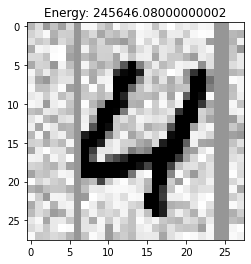

In [41]:
u = noisy_img_removed
sx, sy = grads(noisy_img_removed)
e1 = ALPHA * sx + BETA * sy
e2 = torch.subtract(noisy_img_removed, noisy_img_removed)
e2 = e2.numpy()
e2 = np.square(e2)
e2 = np.multiply(e2, 0.5)
energy = np.add(e1, e2)
plt.title(f"Energy: {np.sum(energy)}")
plt.imshow(u, cmap="Greys")

The energy function is converted into a python function for use later.

In [42]:
def energy(f, u):
    sx, sy = grads(u)
    e1 = ALPHA * sx + BETA * sy
    e2 = torch.subtract(f, u)
    e2 = e2.numpy()
    e2 = np.square(e2)
    e2 = np.multiply(e2, 0.5)
    energy = np.add(e1, e2)
    return np.sum(energy)


The iterative model now begins.
First we will define a learning rate to be used in changing the generated image u.
We will also define an array to store multiple iterations of u through the iterative process.

We then display the given image for inpainting f as a plot.

Then through 5120 iterations we analyze the energy of the function and modify the generated image u depending on the given functional for du/dt.
    In this case however, the time dependent function is replaced through the iterative step process.

U is updated and appended to the iterations array every 64 iterations.

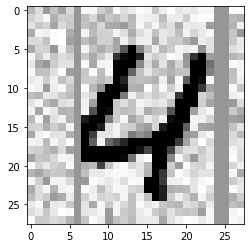

In [43]:
learning_rate = 1e-3
iterations = []
u = torch.zeros(noisy_img.shape)
plt.imshow(noisy_img_removed, cmap="Greys")

for i in range(0, 5120):
    dx, dy = grads(u)
    dxx, dyx = grads(dx/np.sqrt(np.square(dx + 0.0001)))
    dxy, dyy = grads(dy/np.sqrt(np.square(dy + 0.0001)))

    du = np.add((ALPHA * dxx + BETA * dyy), np.subtract(noisy_img_removed, u))
    u = u + learning_rate * du

    if (i % 64 == 0):
        iterations.append(u)


The psnr function here is used to support denoising findings quantitatively. As of currently, it is unused.

In [1]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

The following plot demonstrates u in the first iteration.

It is observed that the scan lines are clearly present and defined.

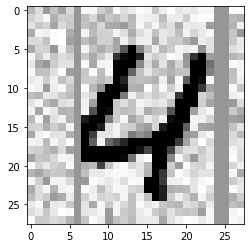

In [45]:
plt.imshow(iterations[0], cmap="Greys")

The following plot shows u in a much later iteration.

Here it is important to note several things. First, the vertical scanlines have been removed and replaced with information that minimized the total variation of the image.

However, it is important to note that the model is significantly more noisy than the given clean image and even the original generated noisy image.

It is believe that this is due to the total variation being reduced non-discriminantly. As such, the noisy existing in the imagr contributes to the addition of noise in the clean image in order to reduce the total energy in comparision to the original given image. Because the model sees the consistent digit color to be in high variation to the surrounding noise, the model contributes extra noise to the generated image to reduce total variation. This is an unintended side effect and its effects must be further anyalyzed.

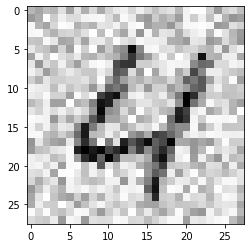

In [116]:
plt.imshow(iterations[630],cmap="Greys")

The following shows several plots at various iterations of the model. It is important to note that the energy of the model quickly reaches convergence.
In this case it is observed to reach convergence by the 2560th iteration and reaches a relative steady state by then.

2000.0
Iteration 0 Energy:14308837.6231685
Iteration 4 Energy:8625198.861702591
Iteration 8 Energy:5296324.662678229
Iteration 12 Energy:3361018.64875597
Iteration 16 Energy:2247289.8946536747
Iteration 20 Energy:1615455.1355105024
Iteration 24 Energy:1264333.8848207253
Iteration 28 Energy:1075200.2253265828
Iteration 32 Energy:978321.3235973692
Iteration 36 Energy:933001.6191735333
Iteration 40 Energy:915698.0033923654
Iteration 44 Energy:912954.4963515374
Iteration 48 Energy:917211.8991189259
Iteration 52 Energy:924330.4366192549
Iteration 56 Energy:932131.0867071997
Iteration 60 Energy:939541.5160085744
Iteration 64 Energy:946099.7656684641
Iteration 68 Energy:951668.7812646104
Iteration 72 Energy:956274.6040426462
Iteration 76 Energy:960016.5590627356
Iteration 80 Energy:963018.9443280576
Iteration 84 Energy:965406.3841986688
Iteration 88 Energy:967292.4280934397
Iteration 92 Energy:968775.0952109178
Iteration 96 Energy:969936.3875258135
Iteration 100 Energy:970843.4616002734
Itera

IndexError: index 5 is out of bounds for axis 0 with size 5

<Figure size 432x288 with 0 Axes>

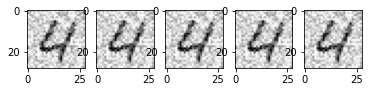

In [117]:
plt.figure()

f, axarr = plt.subplots(1, 5)
plt.set_cmap("Greys")

print(iterations.__len__() / 4)
for i in range (0, iterations.__len__()):
    if i % 4 ==0:
        print(f"Iteration {i} Energy:{energy(noisy_img_removed, iterations[i])}")


for i in range(0, 512):
    print(f"Iteration {(i * 4 - 1, 0)[i ==0]} Energy: {energy(noisy_img, iterations[(i * 4 - 1, 0)[i ==0]])}")
    axarr[i].imshow(iterations[(i * 4 - 1, 0)[i ==0]])